In [9]:
import sys
from utils import get_intervals
sys.path.append('../')
import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
# from numba import njit  # numba requires numpy <= 2.0 

In [38]:
# experiment setup: for a decreasing success probability pi, subsample the number of counts from two Binomial distribution, Bin(X, pi) and Bin(Y, pi), where X and Y are the control and treatment groups' counts. The LFC should (in expectation) be the same but we observe increasingly sparse data. For each pi, we average the LFC estimates over 1000 runs    

# we will consider a range of pi values
pi_range = np.arange(1, 10)[::-1] * 0.1
 
n_cells = 1000
n_runs = 1  # number of times we average the LFC estimates for every pi

data_folder = f"data_from_NB_parameters_r2_5_p_06/n_{n_cells}"
X = pd.read_csv(data_folder + "/control_counts.csv", index_col=0).to_numpy()
Y = pd.read_csv(data_folder + "/treatment_counts.csv", index_col=0).to_numpy()
lfcs = pd.read_csv(data_folder + "/lfcs.csv", index_col=0).to_numpy().reshape(-1)

n_genes = X.shape[-1]
idx = np.argsort(lfcs)  # used for plotting

In [ ]:
adata_X = ad.AnnData(X)
adata_X.obs_names = [f"Cell_{i:d}" for i in range(adata_X.n_obs)]
adata_X.var_names = [f"Gene_{i:d}" for i in range(adata_X.n_vars)]

adata_Y = ad.AnnData(Y)
adata_Y.obs_names = [f"Cell_{i:d}" for i in range(adata_Y.n_obs)]
adata_Y.var_names = [f"Gene_{i:d}" for i in range(adata_Y.n_vars)]

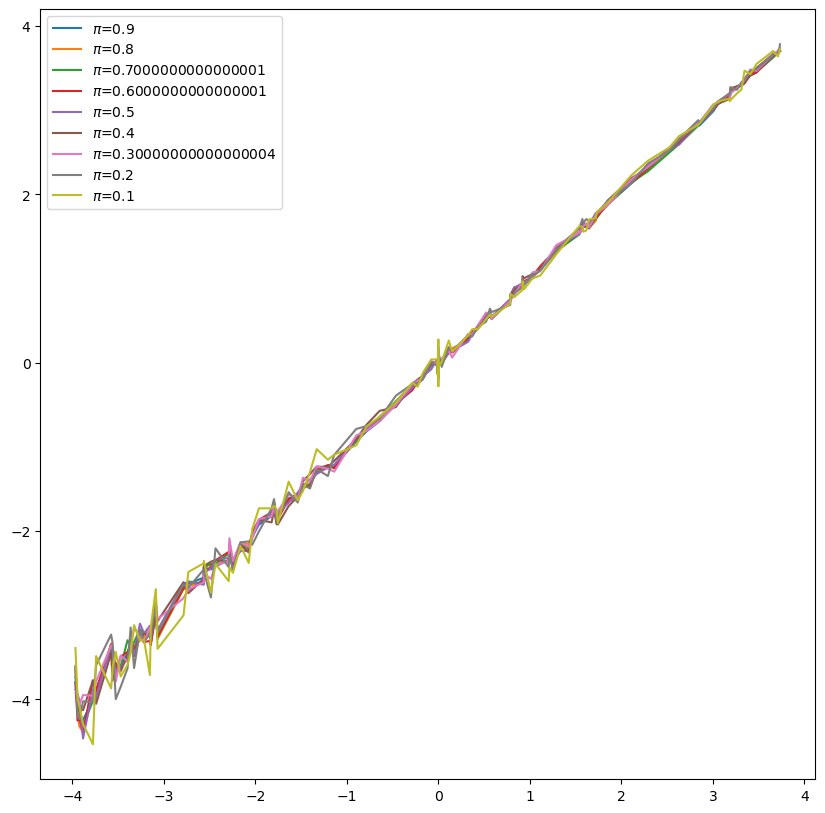

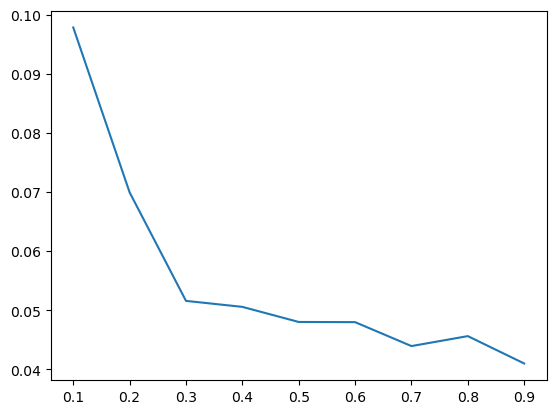

In [39]:
def main(X, Y, pi_range, n_runs, n_genes):
    estimated_lfcs = np.zeros((len(pi_range), n_genes))
    for k, pi in enumerate(pi_range):
        for g in range(n_genes):            
            estimated_lfcs_g = []  # store every LFC estimate in each run
            for i in range(n_runs):
                x = np.random.binomial(X[:, g].astype(np.int64), pi)
                y = np.random.binomial(Y[:, g].astype(np.int64), pi)
                
                x_N_plus = np.sum(x > 0, axis=0)
                x_N_0 = np.sum(x == 0, axis=0)
                log_x = np.log(x[x>0])
                _, log_mu_x, _ = get_intervals(log_x, x_N_plus, x_N_0, eps=1e-3)
                
                
                y_N_plus = np.sum(y > 0, axis=0)
                y_N_0 = np.sum(y == 0, axis=0)
                log_y = np.log(y[y>0])
                _, log_mu_y, _ = get_intervals(log_y, y_N_plus, y_N_0, eps=1e-3)
                
                estimated_lfc = log_mu_y - log_mu_x
                estimated_lfcs_g.append(estimated_lfc)
            
            estimated_lfcs[k, g] = np.mean(estimated_lfcs_g)
    return estimated_lfcs

estimated_lfcs = main(X, Y, pi_range, n_runs, n_genes)

plt.figure(figsize=(10, 10))
for k, pi in enumerate(pi_range):
    plt.plot(lfcs[idx], estimated_lfcs[k][idx], label=f'$\pi$={pi}')
plt.legend(loc='upper left')
plt.show()

rmses = []
for k, pi in enumerate(pi_range):
    rmse = np.sqrt(np.mean((lfcs - estimated_lfcs[k])**2))
    rmses.append(rmse)
plt.plot(pi_range, rmses)
plt.show()



/home/oskar/anaconda3/envs/pythonProject/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/oskar/anaconda3/envs/pythonProject/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/oskar/anaconda3/envs/pythonProject/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/oskar/anaconda3/envs/pythonProject/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/oskar/anaconda3/envs/pythonProject/lib/python3

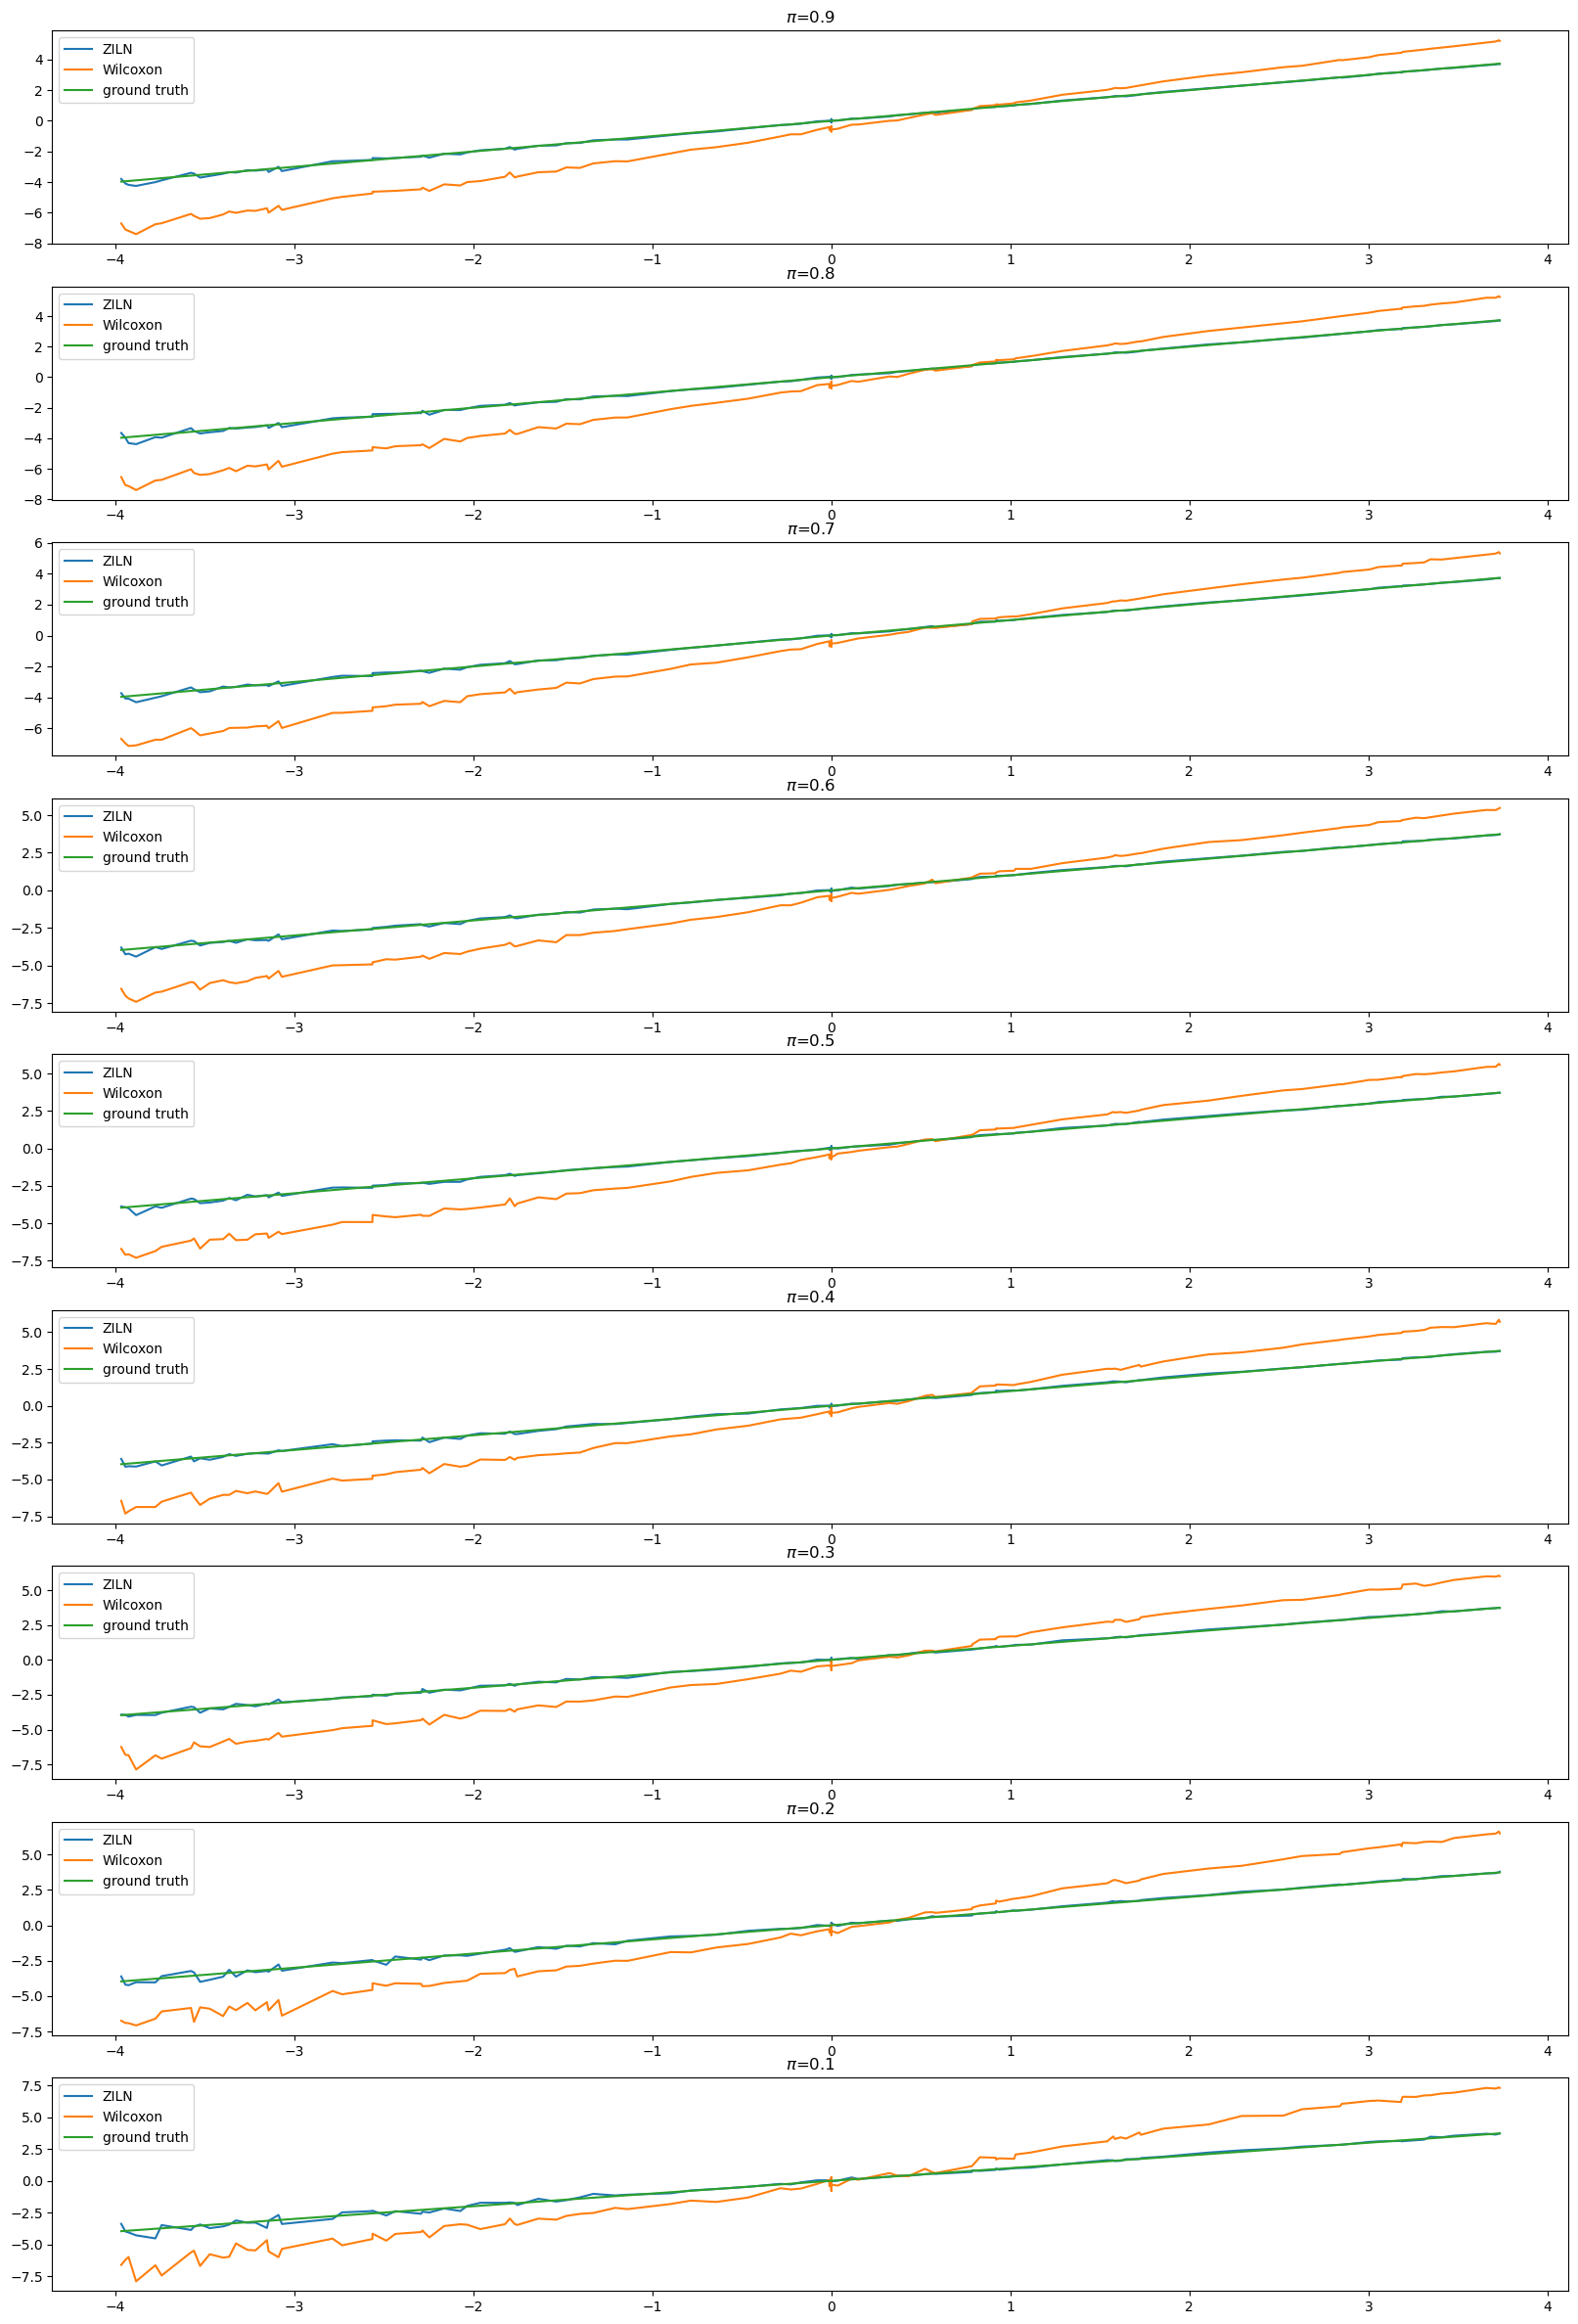

In [40]:
def wilcoxon_test(X, Y):
    # Assuming X and Y are numpy arrays of raw counts
    # X: Group 1 (n_cells_x x n_genes)
    # Y: Group 2 (n_cells_y x n_genes)
    
    # Create AnnData objects for the two groups
    adata_x = ad.AnnData(X)
    adata_y = ad.AnnData(Y)
    
    # Concatenate the two groups into one AnnData object
    adata = ad.concat([adata_x, adata_y], label="group", keys=["Group1", "Group2"])
    adata.obs['group'] = adata.obs['group'].astype('category')  # Ensure 'group' is categorical
    
    # Normalize the data (library size normalization + log transformation)
    sc.pp.normalize_total(adata, target_sum=1e4)  # Normalize counts per cell to 10,000
    sc.pp.log1p(adata)  # Log-transform the data
    
    # Run the Wilcoxon Rank-Sum Test
    sc.tl.rank_genes_groups(adata, groupby='group', method='wilcoxon')
    
    # Extract results for Group2 vs Group1
    result = adata.uns['rank_genes_groups']
    groups = result['names'].dtype.names  # Get group names
    wilcoxon_results = pd.DataFrame({
        'gene': result['names'][groups[1]],  # Group2 vs Group1
        'logfoldchange': result['logfoldchanges'][groups[1]],
        'pval': result['pvals'][groups[1]],
        'pval_adj': result['pvals_adj'][groups[1]]
    })
    
    # Sort by log-fold change for inspection
    wilcoxon_results['gene'] = wilcoxon_results['gene'].astype(int)
    wilcoxon_results.sort_values(by='gene', ascending=True, inplace=True)
    lfcs_wilcoxon = np.array(wilcoxon_results.logfoldchange)
    # plt.plot(lfcs[idx], lfcs_wilcoxon[idx], label='wilcoxon estimates')
    # plt.plot(lfcs[idx], lfcs[idx], label='ground truth')
    # plt.legend(loc='upper left')
    # plt.show()
    return lfcs_wilcoxon


_, ax = plt.subplots(len(pi_range), figsize=(20, 30))
for k, pi in enumerate(pi_range):
    X_pi = np.random.binomial(X.astype(np.int64), pi)
    Y_pi = np.random.binomial(Y.astype(np.int64), pi)
    lfcs_wilcoxon = wilcoxon_test(X_pi, Y_pi)

    ax[k].set_title(f'$\pi$={round(pi, 1)}')
    ax[k].plot(lfcs[idx], estimated_lfcs[k][idx], label='ZILN')
    ax[k].plot(lfcs[idx], lfcs_wilcoxon[idx], label='Wilcoxon')
    ax[k].plot(lfcs[idx], lfcs[idx], label='ground truth')
    ax[k].legend(loc='upper left')
plt.show()
